In [1]:
import pandas as pd
from sklift.models import TwoModels
import lightgbm as lgb
from sklift import models, viz
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.base import clone
from matplotlib import pyplot as plt

# Data

In [7]:
data_path = "../../data/preprocessed/"  # features_with_target.csv

transaction_features = pd.read_csv(data_path + "x5_transaction_features.csv", index_col="client_id")
client_features = pd.read_csv(data_path + "x5_client_features.csv", index_col="client_id")
df_target = pd.read_csv("../../data/datasets/x5-retail-hero/uplift_train.csv.gz", index_col="client_id")
df = transaction_features.join(client_features).join(df_target)
df

,regular_points_received_mean,regular_points_received_std,regular_points_received_median,regular_points_received_max,regular_points_received_skew,express_points_received_mean,express_points_received_std,express_points_received_median,express_points_received_max,express_points_received_skew,...,percent_of_transactions_in_12_month,age,first_issue_time,first_redeem_time,issue_redeem_delay,F,M,U,treatment_flg,target
client_id,,,,,,,,,,,,,,,,,,,,,
000012768d,6.425000,2.973529,6.85,10.0,-0.355890,0.000,0.000000,0.0,0.0,0.000000,...,2,45,0.336675,0.735365,0.398690,0,0,1,0,1
000036f903,1.715625,1.461401,1.30,7.0,2.367965,1.875,10.439558,0.0,60.0,5.388159,...,10,72,0.015925,0.033211,0.017286,1,0,0,1,1
00010925a5,1.766667,1.139688,1.45,5.8,2.321282,0.000,0.000000,0.0,0.0,0.000000,...,6,83,1.303876,1.428140,0.124264,0,0,1,1,1
0001f552b0,5.260000,9.686334,1.60,39.7,2.953750,0.000,0.000000,0.0,0.0,0.000000,...,4,33,0.238463,1.381198,1.142734,1,0,0,1,1
00020e7b18,15.894444,13.081389,14.60,44.5,0.819229,0.000,0.000000,0.0,0.0,0.000000,...,2,73,0.648549,0.751613,0.103064,0,0,1,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
fffe0abb97,2.466667,3.003701,0.70,7.3,0.703218,0.000,0.000000,0.0,0.0,0.000000,...,1,35,0.648236,0.838325,0.190090,1,0,0,0,0
fffe0ed719,2.330000,2.281542,1.50,8.6,1.531437,0.000,0.000000,0.0,0.0,0.000000,...,4,69,0.448229,0.671819,0.223590,0,0,1,0,1
fffea1204c,1.535294,1.710845,0.90,5.9,1.563107,0.000,0.000000,0.0,0.0,0.000000,...,4,73,0.827236,0.918646,0.091409,1,0,0,0,1


In [8]:
def split_df(df, columns = None):
    features = df[df.columns.difference(['treatment_flg', 'target', 'client_id', 'gender'])]
    if columns is not None:
        features = features[columns]
    y_target = df.target
    treatment = df.treatment_flg
    
    return features, y_target, treatment

### Split

In [9]:
from sklearn.model_selection import train_test_split

df_train, df_test = train_test_split(df, train_size=0.8, stratify=df.treatment_flg, random_state=42)

# Models

## Two tower models

#### TwoTowerModel

In [10]:
treatment_model = lgb.LGBMClassifier()
control_model = lgb.LGBMClassifier()

uplift_model = TwoModels(treatment_model, control_model, )
uplift_model.fit(*split_df(df_train))
uplift_predict = uplift_model.predict(split_df(df_test)[0])

#### TwoTowerModel + Logreg

In [11]:
logreg_model = make_pipeline(StandardScaler(), LogisticRegression(max_iter=10_000))

ttlogreg_model = TwoModels(clone(logreg_model), clone(logreg_model))
ttlogreg_model.fit(*split_df(df_train))
ttlogreg_predict = ttlogreg_model.predict(split_df(df_test)[0])

## Class Transformation models

#### Class Transformation + LGBM

In [12]:
ct_model = models.ClassTransformation(lgb.LGBMClassifier())
ct_model.fit(*split_df(df_train))
ct_predict = ct_model.predict(split_df(df_test)[0])

/home/isabella/code/study/diploma/venv/lib/python3.7/site-packages/ipykernel_launcher.py:2: UserWarning: It is recommended to use this approach on treatment balanced data. Current sample size is unbalanced.
  


#### Class Transformation + LogReg

In [13]:
ctlogreg_model = models.ClassTransformation(clone(logreg_model))
ctlogreg_model.fit(*split_df(df_train))
ctlogreg_predict = ctlogreg_model.predict(split_df(df_test)[0])

/home/isabella/code/study/diploma/venv/lib/python3.7/site-packages/ipykernel_launcher.py:2: UserWarning: It is recommended to use this approach on treatment balanced data. Current sample size is unbalanced.
  


## Metrics

In [14]:
features_test, y_test, treatment_test = split_df(df_test)

### Uplift curve

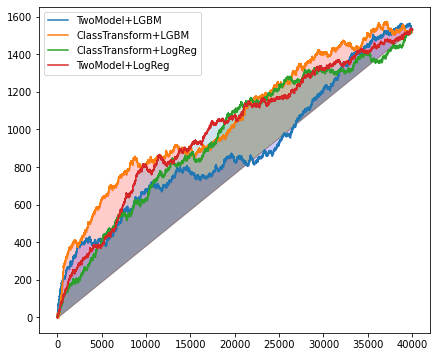

In [16]:
def plot_uplift_curve(target, uplift, treatment, ax, plot_kwargs, fillbetween_kwargs):
    x, y = viz.base.uplift_curve(target, uplift, treatment)
    y_baseline = x * y[-1] / len(target)
    ax.plot(x, y, **plot_kwargs)
    ax.fill_between(x, y, y_baseline, **fillbetween_kwargs)
    return ax


fig, ax = plt.subplots(figsize=(7, 6))
plot_uplift_curve(y_test, uplift_predict, treatment_test, ax, 
                  {'label': 'TwoModel+LGBM'}, 
                  {'color': 'blue', 'alpha': 0.2})
plot_uplift_curve(y_test, ct_predict, treatment_test, ax, 
                  {'label': 'ClassTransform+LGBM'}, 
                  {'color': 'red', 'alpha': 0.2})
plot_uplift_curve(y_test, ctlogreg_predict, treatment_test, ax, 
                  {'label': 'ClassTransform+LogReg'}, 
                  {'color': 'green', 'alpha': 0.2})
plot_uplift_curve(y_test, ttlogreg_predict, treatment_test, ax, 
                  {'label': 'TwoModel+LogReg'}, 
                  {'alpha': 0.2})
ax.legend()

### Uplift@30

In [17]:
from sklift import metrics

print("TT+LGBM Uplift@30:", metrics.uplift_at_k(y_test, uplift_predict, treatment_test, strategy="by_group", k = 0.3))
print("TT+LogReg Uplift@30:", metrics.uplift_at_k(y_test, ttlogreg_predict, treatment_test, strategy="by_group", k = 0.3))
print("CT+LGBM Uplift@30:", metrics.uplift_at_k(y_test, ct_predict, treatment_test, strategy="by_group", k = 0.3))
print("CT+LogReg Uplift@30:", metrics.uplift_at_k(y_test, ctlogreg_predict, treatment_test, strategy="by_group", k = 0.3))

TT+LGBM Uplift@30: 0.05763009903295546
TT+LogReg Uplift@30: 0.06893138403566917
CT+LGBM Uplift@30: 0.07098301466139223
CT+LogReg Uplift@30: 0.06209188392354903
